### Understanding Spotify's Song recommender system based on User Data 

 - Code adapted from Week 3- Spotify-playlist.ipynb ( available at: https://git.arts.ac.uk/lmccallum/personalisation-23-24/blob/main/week-3-spotify-playlists.ipynb) and debugged using ChatGpt-4

In [80]:
!pip3 install spotipy

import os
import spotipy
import numpy as np
import pandas as pd
import seaborn as sns
!pip3 install spotipy
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import defaultdict
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.metrics.pairwise import cosine_similarity as cosine

### Data Retrieval using Spotify API

In [3]:
# Authentication 
SPOTIFY_CLIENT_ID ='6b50aedcc26c4a64b181d2380ce6ef08'
SPOTIFY_CLIENT_SECRET = 'a042c64724114070884a19a8a9f3ecc8'

auth_manager = SpotifyClientCredentials(SPOTIFY_CLIENT_ID,SPOTIFY_CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [4]:
# Outline target song 
song_name = ' Waiting For You (feat. Naomi Sharon) '
artist_name = ' Majid Jordan (feat Naomi Sharon)'

results = sp.search(q=f'track:{song_name} artist:{artist_name}', limit=1, type='track')
if results['tracks']['items']:
    track_id = results['tracks']['items'][0]['id']
else:
    print('x')

In [5]:
# Retrieve a sample of playlists with the chosen song as a radio
playlists = sp.search(q=f'track:{song_name} artist:{artist_name}', type='playlist')
track_data = []
print(playlists)

{'playlists': {'href': 'https://api.spotify.com/v1/search?query=track%3A+Waiting+For+You+%28feat.+Naomi+Sharon%29++artist%3A+Majid+Jordan+%28feat+Naomi+Sharon%29&type=playlist&offset=0&limit=10', 'items': [{'collaborative': False, 'description': 'With dvsn, Roy Woods, Ramriddlz and more', 'external_urls': {'spotify': 'https://open.spotify.com/playlist/37i9dQZF1E4k3kpnSrSHNR'}, 'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1E4k3kpnSrSHNR', 'id': '37i9dQZF1E4k3kpnSrSHNR', 'images': [{'height': None, 'url': 'https://seeded-session-images.scdn.co/v2/img/540/r/artist/4HzKw8XcD0piJmDrrPRCYk/en', 'width': None}], 'name': 'Majid Jordan Radio', 'owner': {'display_name': 'Spotify', 'external_urls': {'spotify': 'https://open.spotify.com/user/spotify'}, 'href': 'https://api.spotify.com/v1/users/spotify', 'id': 'spotify', 'type': 'user', 'uri': 'spotify:user:spotify'}, 'primary_color': None, 'public': None, 'snapshot_id': 'MTcxNzkzNzIwOSwwMDAwMDAwMDUyNzQ0OGVlMDk5YTllMDBmMWNiMDU3MWVkNGM0NmFj

In [6]:
# Iterate through the search results, finding all playlist data available.
for playlist in playlists['playlists']['items']:
    # Get the playlist ID
    playlist_id = playlist['id']
    
    # Retrieve tracks from the playlist
    playlist_tracks = sp.playlist_tracks(playlist_id)

    # Instatiate a dictionary for the results to be stored
    track_ids = []
    
    # Iterate through the tracks in the playlist
    for item in playlist_tracks['items']:
        track = item['track']
        # Extract track information
        track_name = track['name']
        track_artist = ', '.join([artist['name'] for artist in track['artists']])
        track_album = track['album']['name']
        track_popularity = track['popularity']
        
        # Retrieve genre information for each artist
        artist_ids = [artist['id'] for artist in track['artists']]
        artist_genres = []
        for artist_id in artist_ids:
            artist_info = sp.artist(artist_id)
            artist_genres.extend(artist_info['genres'])
        artist_genres = list(set(artist_genres))  # Remove duplicates
        genres_str = ', '.join(artist_genres)
        
        audio_features = sp.audio_features(track['id'])[0] # The following column names were outlines and extracted from Spotify's API documentation, available at: https://developer.spotify.com/documentation/web-api.
        track_data.append({
            'playlist_name': playlist['name'],
            'track_id': track['id'],
            'track_name': track_name,
            'track_artist': track_artist,
            'track_album': track_album,
            'track_popularity': track_popularity,
            'track_genres': genres_str,
            'danceability': audio_features['danceability'],
            'energy': audio_features['energy'],
            'key': audio_features['key'],
            'loudness': audio_features['loudness'],
            'mode': audio_features['mode'],
            'speechiness': audio_features['speechiness'],
            'acousticness': audio_features['acousticness'],
            'instrumentalness': audio_features['instrumentalness'],
            'liveness': audio_features['liveness'],
            'valence': audio_features['valence'],
            'tempo': audio_features['tempo'],
            'duration_ms': audio_features['duration_ms'],
            'time_signature': audio_features['time_signature'] })
       

df = pd.DataFrame(track_data)
df # Print to ensure the above following has been places into a well structured datafame.

,playlist_name,track_id,track_name,track_artist,track_album,track_popularity,track_genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Majid Jordan Radio,4Wfe2jloKo95eFVnJEr5N1,Her,Majid Jordan,A Place Like This,49,"canadian contemporary r&b, canadian hip hop",0.676,0.500,1,-6.603,1,0.0513,0.00371,0.002780,0.1140,0.0742,90.030,300729,4
1,Majid Jordan Radio,7DfFc7a6Rwfi3YQMRbDMau,Thinkin Bout You,Frank Ocean,channel ORANGE,80,"neo soul, lgbtq+ hip hop",0.721,0.339,0,-11.195,1,0.0532,0.40900,0.001530,0.0973,0.2000,129.830,200747,4
2,Majid Jordan Radio,2pg2TiYo9Rb8KeB5JjP7jS,Sativa,"Jhené Aiko, Swae Lee",Trip,74,"melodic rap, rap, trap, r&b",0.741,0.610,6,-7.340,0,0.0511,0.31600,0.000000,0.5340,0.7200,125.990,276960,4
3,Majid Jordan Radio,6oEVnWKgPqIEPc53OYDNqG,Could've Been (feat. Bryson Tiller),"H.E.R., Bryson Tiller",I Used To Know Her,72,"rap, kentucky hip hop, r&b",0.450,0.352,1,-11.733,0,0.2670,0.64900,0.000004,0.2490,0.4080,102.679,252747,4
4,Majid Jordan Radio,3a3dQOO19moXPeTt2PomoT,What You Heard,Sonder,What You Heard,72,experimental r&b,0.429,0.371,2,-9.017,0,0.0327,0.54600,0.000006,0.1040,0.1350,137.134,238242,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,Ari Lennox Mix,6efkcs2aUBMFKxl0cl2JWQ,Wild Irish Roses,Smino,blkswn,59,alternative r&b,0.635,0.295,0,-11.237,0,0.5430,0.56100,0.000032,0.3000,0.6360,86.673,169320,4
601,Ari Lennox Mix,2q4cLqUTbjtvlXIcaa85TA,Facetime,Ari Lennox,Shea Butter Baby,35,alternative r&b,0.754,0.504,6,-7.174,0,0.0405,0.36300,0.000025,0.0964,0.7970,78.014,151674,4
602,Ari Lennox Mix,23c9gmiiv7RCu7twft0Mym,Who Hurt You?,Daniel Caesar,Who Hurt You?,64,canadian contemporary r&b,0.649,0.493,11,-7.645,0,0.1100,0.58600,0.000167,0.0667,0.2770,104.542,231964,4
603,Ari Lennox Mix,5xpU73nutoJizKpX3TZRhS,Blackberry Sap (with Ari Lennox),"Dreamville, Ari Lennox",D-Day: A Gangsta Grillz Mixtape,37,"underground hip hop, hip hop, pop rap, rap, al...",0.777,0.551,2,-7.774,1,0.0907,0.12600,0.000000,0.0957,0.6740,125.960,149739,4


In [7]:
# Data preparation e.g, removing NaN values before clustering. Although this significantly drops the overall dataset by roughly 50%
df = df.drop_duplicates(subset=['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'])
df = df.dropna(subset=['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'])
df

,playlist_name,track_id,track_name,track_artist,track_album,track_popularity,track_genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Majid Jordan Radio,4Wfe2jloKo95eFVnJEr5N1,Her,Majid Jordan,A Place Like This,49,"canadian contemporary r&b, canadian hip hop",0.676,0.500,1,-6.603,1,0.0513,0.00371,0.002780,0.1140,0.0742,90.030,300729,4
1,Majid Jordan Radio,7DfFc7a6Rwfi3YQMRbDMau,Thinkin Bout You,Frank Ocean,channel ORANGE,80,"neo soul, lgbtq+ hip hop",0.721,0.339,0,-11.195,1,0.0532,0.40900,0.001530,0.0973,0.2000,129.830,200747,4
2,Majid Jordan Radio,2pg2TiYo9Rb8KeB5JjP7jS,Sativa,"Jhené Aiko, Swae Lee",Trip,74,"melodic rap, rap, trap, r&b",0.741,0.610,6,-7.340,0,0.0511,0.31600,0.000000,0.5340,0.7200,125.990,276960,4
3,Majid Jordan Radio,6oEVnWKgPqIEPc53OYDNqG,Could've Been (feat. Bryson Tiller),"H.E.R., Bryson Tiller",I Used To Know Her,72,"rap, kentucky hip hop, r&b",0.450,0.352,1,-11.733,0,0.2670,0.64900,0.000004,0.2490,0.4080,102.679,252747,4
4,Majid Jordan Radio,3a3dQOO19moXPeTt2PomoT,What You Heard,Sonder,What You Heard,72,experimental r&b,0.429,0.371,2,-9.017,0,0.0327,0.54600,0.000006,0.1040,0.1350,137.134,238242,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,Ari Lennox Mix,5toSnLJgSEwlnNzq61t63x,40 Shades of Choke,Ari Lennox,40 Shades of Choke,36,alternative r&b,0.733,0.508,5,-7.962,1,0.4610,0.61900,0.004520,0.0491,0.8670,104.620,212670,4
600,Ari Lennox Mix,6efkcs2aUBMFKxl0cl2JWQ,Wild Irish Roses,Smino,blkswn,59,alternative r&b,0.635,0.295,0,-11.237,0,0.5430,0.56100,0.000032,0.3000,0.6360,86.673,169320,4
601,Ari Lennox Mix,2q4cLqUTbjtvlXIcaa85TA,Facetime,Ari Lennox,Shea Butter Baby,35,alternative r&b,0.754,0.504,6,-7.174,0,0.0405,0.36300,0.000025,0.0964,0.7970,78.014,151674,4
602,Ari Lennox Mix,23c9gmiiv7RCu7twft0Mym,Who Hurt You?,Daniel Caesar,Who Hurt You?,64,canadian contemporary r&b,0.649,0.493,11,-7.645,0,0.1100,0.58600,0.000167,0.0667,0.2770,104.542,231964,4


In [8]:
# Standardize features then implement into a K-means cluster. This aids in the analysis between playlists.
scaler = StandardScaler()
features = df[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
scaled_features = scaler.fit_transform(features)
df

,playlist_name,track_id,track_name,track_artist,track_album,track_popularity,track_genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Majid Jordan Radio,4Wfe2jloKo95eFVnJEr5N1,Her,Majid Jordan,A Place Like This,49,"canadian contemporary r&b, canadian hip hop",0.676,0.500,1,-6.603,1,0.0513,0.00371,0.002780,0.1140,0.0742,90.030,300729,4
1,Majid Jordan Radio,7DfFc7a6Rwfi3YQMRbDMau,Thinkin Bout You,Frank Ocean,channel ORANGE,80,"neo soul, lgbtq+ hip hop",0.721,0.339,0,-11.195,1,0.0532,0.40900,0.001530,0.0973,0.2000,129.830,200747,4
2,Majid Jordan Radio,2pg2TiYo9Rb8KeB5JjP7jS,Sativa,"Jhené Aiko, Swae Lee",Trip,74,"melodic rap, rap, trap, r&b",0.741,0.610,6,-7.340,0,0.0511,0.31600,0.000000,0.5340,0.7200,125.990,276960,4
3,Majid Jordan Radio,6oEVnWKgPqIEPc53OYDNqG,Could've Been (feat. Bryson Tiller),"H.E.R., Bryson Tiller",I Used To Know Her,72,"rap, kentucky hip hop, r&b",0.450,0.352,1,-11.733,0,0.2670,0.64900,0.000004,0.2490,0.4080,102.679,252747,4
4,Majid Jordan Radio,3a3dQOO19moXPeTt2PomoT,What You Heard,Sonder,What You Heard,72,experimental r&b,0.429,0.371,2,-9.017,0,0.0327,0.54600,0.000006,0.1040,0.1350,137.134,238242,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,Ari Lennox Mix,5toSnLJgSEwlnNzq61t63x,40 Shades of Choke,Ari Lennox,40 Shades of Choke,36,alternative r&b,0.733,0.508,5,-7.962,1,0.4610,0.61900,0.004520,0.0491,0.8670,104.620,212670,4
600,Ari Lennox Mix,6efkcs2aUBMFKxl0cl2JWQ,Wild Irish Roses,Smino,blkswn,59,alternative r&b,0.635,0.295,0,-11.237,0,0.5430,0.56100,0.000032,0.3000,0.6360,86.673,169320,4
601,Ari Lennox Mix,2q4cLqUTbjtvlXIcaa85TA,Facetime,Ari Lennox,Shea Butter Baby,35,alternative r&b,0.754,0.504,6,-7.174,0,0.0405,0.36300,0.000025,0.0964,0.7970,78.014,151674,4
602,Ari Lennox Mix,23c9gmiiv7RCu7twft0Mym,Who Hurt You?,Daniel Caesar,Who Hurt You?,64,canadian contemporary r&b,0.649,0.493,11,-7.645,0,0.1100,0.58600,0.000167,0.0667,0.2770,104.542,231964,4


In [9]:
# add track name into the columns for later retrieval
print(df.columns)
print(df.index)

Index(['playlist_name', 'track_id', 'track_name', 'track_artist',
       'track_album', 'track_popularity', 'track_genres', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature'],
      dtype='object')
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       594, 595, 596, 597, 598, 599, 600, 601, 602, 603],
      dtype='int64', length=556)


In [10]:
df

,playlist_name,track_id,track_name,track_artist,track_album,track_popularity,track_genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Majid Jordan Radio,4Wfe2jloKo95eFVnJEr5N1,Her,Majid Jordan,A Place Like This,49,"canadian contemporary r&b, canadian hip hop",0.676,0.500,1,-6.603,1,0.0513,0.00371,0.002780,0.1140,0.0742,90.030,300729,4
1,Majid Jordan Radio,7DfFc7a6Rwfi3YQMRbDMau,Thinkin Bout You,Frank Ocean,channel ORANGE,80,"neo soul, lgbtq+ hip hop",0.721,0.339,0,-11.195,1,0.0532,0.40900,0.001530,0.0973,0.2000,129.830,200747,4
2,Majid Jordan Radio,2pg2TiYo9Rb8KeB5JjP7jS,Sativa,"Jhené Aiko, Swae Lee",Trip,74,"melodic rap, rap, trap, r&b",0.741,0.610,6,-7.340,0,0.0511,0.31600,0.000000,0.5340,0.7200,125.990,276960,4
3,Majid Jordan Radio,6oEVnWKgPqIEPc53OYDNqG,Could've Been (feat. Bryson Tiller),"H.E.R., Bryson Tiller",I Used To Know Her,72,"rap, kentucky hip hop, r&b",0.450,0.352,1,-11.733,0,0.2670,0.64900,0.000004,0.2490,0.4080,102.679,252747,4
4,Majid Jordan Radio,3a3dQOO19moXPeTt2PomoT,What You Heard,Sonder,What You Heard,72,experimental r&b,0.429,0.371,2,-9.017,0,0.0327,0.54600,0.000006,0.1040,0.1350,137.134,238242,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,Ari Lennox Mix,5toSnLJgSEwlnNzq61t63x,40 Shades of Choke,Ari Lennox,40 Shades of Choke,36,alternative r&b,0.733,0.508,5,-7.962,1,0.4610,0.61900,0.004520,0.0491,0.8670,104.620,212670,4
600,Ari Lennox Mix,6efkcs2aUBMFKxl0cl2JWQ,Wild Irish Roses,Smino,blkswn,59,alternative r&b,0.635,0.295,0,-11.237,0,0.5430,0.56100,0.000032,0.3000,0.6360,86.673,169320,4
601,Ari Lennox Mix,2q4cLqUTbjtvlXIcaa85TA,Facetime,Ari Lennox,Shea Butter Baby,35,alternative r&b,0.754,0.504,6,-7.174,0,0.0405,0.36300,0.000025,0.0964,0.7970,78.014,151674,4
602,Ari Lennox Mix,23c9gmiiv7RCu7twft0Mym,Who Hurt You?,Daniel Caesar,Who Hurt You?,64,canadian contemporary r&b,0.649,0.493,11,-7.645,0,0.1100,0.58600,0.000167,0.0667,0.2770,104.542,231964,4


### Exploring song similarity based on acoustic features (as provided by thr Spotify API)

In [11]:
# Upgrade and install visualisation libraries for a radar plot as opposed to a heat map.
import sys
print(sys.executable)

# Install Plotly using the correct Python executable
!{sys.executable} -m pip install plotly --upgrade

/Users/nixi/anaconda3/envs/stem/bin/python


In [12]:
# Ensure the target song has also had features extracted
track_features = sp.audio_features(track_id) 
waiting_for_you_features = pd.DataFrame([track_features[0]], index=[song_name])

# Standardize features of 'Waiting For You' using the same scaler used for the DataFrame
waiting_for_you_scaled = scaler.transform(waiting_for_you_features[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']])


# Calculate cosine similarity between 'Waiting For You' and all tracks in the DataFrame
similarities = cosine(waiting_for_you_scaled, scaled_features)  # 'scaled_features' should be the scaled features of all other tracks
similarities_df = pd.DataFrame(similarities, index=[song_name], columns=df.index)

waiting_for_you_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
Waiting For You (feat. Naomi Sharon),0.744,0.575,10,-5.199,0,0.0383,0.598,0.00932,0.105,0.581,81.976,audio_features,6Dae6DNW72nLZ6KGyE7aeH,spotify:track:6Dae6DNW72nLZ6KGyE7aeH,https://api.spotify.com/v1/tracks/6Dae6DNW72nL...,https://api.spotify.com/v1/audio-analysis/6Dae...,219999,4


In [13]:
# Outline features in df
features_df = df[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)
waiting_for_you_scaled = scaler.transform(waiting_for_you_features[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']])

# Calculate cosine similarity
similarities = cosine(waiting_for_you_scaled, features_scaled)

# Convert similarities to a DataFrame for easier handling
similarities_df = pd.DataFrame(similarities, columns=df.index, index=['Waiting For You'])

In [14]:
# Scatter plot of the similarities
fig = go.Figure(data=[
    go.Scatter(
        x=similarities_df.columns,  #  similarities_df for the x-axis
        y=similarities_df.loc['Waiting For You'],  # scores for the y-axis
        mode='markers',
        marker=dict(size=10, color='LightSkyBlue'),
        text=similarities_df.columns,  # Optionally, use the track names as hover text
        hoverinfo='text'
    ),
])

fig.update_layout(
    title='Similarity of Spotify Tracks to "Waiting For You"',
    xaxis_title='Track Number',
    yaxis_title='Similarity Score',
    xaxis={'categoryorder':'total descending'})

fig.show()

### K-Means Clustering

In [15]:
# The original code assigned all the called playlists to a single cluster, which would prove invaluable towards analysis of musicality.
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42) # chose 5 clusters 
df.loc[:, 'cluster'] = kmeans.fit_predict(scaled_features)

# Analyze clusters
clustered_playlists = df.groupby(['playlist_name', 'cluster']).size().unstack(fill_value=0)
print(clustered_playlists)

cluster                                      0  1   2   3   4
playlist_name                                                
Aliya Janell's Taste                        13  3   3  31   0
Ari Lennox Mix                              10  3  12  15   1
Love Deluxe                                  0  7  26  16   1
Majid Jordan Radio                           1  8  18  23   0
Majid Jordan: THE PLAYLIST                   5  8  17  47  15
Tems Complete                               18  1   7  14   2
This Is Majid Jordan                         1  4  14  19   2
Vanguard                                     8  8  41  40   2
Waiting For You (feat. Naomi Sharon)         8  1  23  13   6
Waiting For You (feat. Naomi Sharon) Radio   3  2  23   8   5


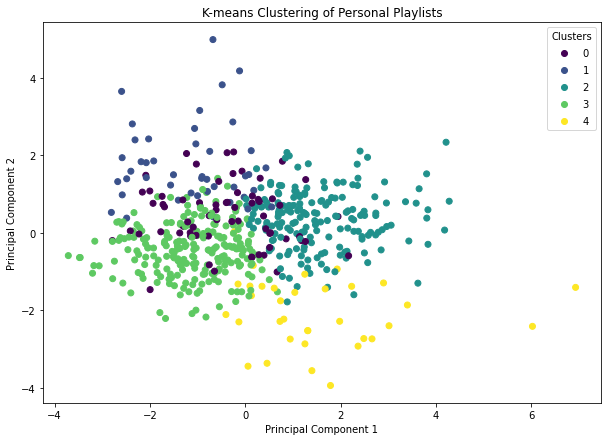

In [16]:
# Apply PCA to reduce to feature values to 2 dimensions
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
df['pc1'] = principal_components[:, 0]
df['pc2'] = principal_components[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df['pc1'], df['pc2'], c=df['cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering of Personal Playlists')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


In [17]:
# Inspect dataset and check for variance. This showed that there was little within my dataset, hence why the k-means cluster assigned only one cluster for the entirrety of my spotify dataset.
print(df.describe())

       track_popularity  danceability      energy         key    loudness  \
count        556.000000    556.000000  556.000000  556.000000  556.000000   
mean          46.330935      0.660121    0.511694    5.363309   -8.848428   
std           17.463842      0.132865    0.162095    3.516912    2.955282   
min            0.000000      0.116000    0.090800    0.000000  -22.540000   
25%           39.000000      0.582000    0.406000    2.000000  -10.532750   
50%           48.000000      0.678000    0.501000    6.000000   -8.397000   
75%           56.000000      0.750500    0.625500    8.000000   -6.762750   
max           94.000000      0.965000    0.943000   11.000000   -2.341000   

             mode  speechiness  acousticness  instrumentalness    liveness  \
count  556.000000   556.000000    556.000000        556.000000  556.000000   
mean     0.453237     0.106524      0.361307          0.058203    0.151530   
std      0.498257     0.107759      0.274407          0.174061    0.1158

### Considering song popularity as user feedback

In [18]:
## Incorporate the popularity of the track into for profiling user preferences and behaviors.
scaler = MinMaxScaler()

# Scale the 'track_popularity' column
df['popularity_scaled'] = scaler.fit_transform(df[['track_popularity']])

# Check the output to ensure the scaling is applied correctly
print(df[['track_popularity', 'popularity_scaled']].head())

   track_popularity  popularity_scaled
0                49           0.521277
1                80           0.851064
2                74           0.787234
3                72           0.765957
4                72           0.765957


In [19]:
# With this analysis, adjusting recommendations by popularity
top_n_similar_tracks = similarities_df.T.sort_values(by='Waiting For You', ascending=False)

# Add similarity scores to 'df', making sure that the index of 'df' matches the index of 'top_n_similar_tracks'
df['similarity_scores'] = top_n_similar_tracks['Waiting For You']

# Calculate the recommendation score
df['recommendation_score'] = (0.8 * df['similarity_scores']) + (0.2 * df['popularity_scaled'])

# Sort DataFrame by recommendation score to get top recommendations
top_recommendations = df.sort_values(by='recommendation_score', ascending=False).head(10)

# Print the top recommendations
print(top_recommendations)

                                  playlist_name                track_id  \
53                         This Is Majid Jordan  6Dae6DNW72nLZ6KGyE7aeH   
5                            Majid Jordan Radio  6ARYP4KyGydosXyxtzlDdc   
582                              Ari Lennox Mix  7DswEZZthZ6piQpL25qGAM   
419                               Tems Complete  3cuUZnjDwk4cUJCFinYbAC   
362                        Aliya Janell's Taste  6zMUIb4uce1CzpbjR3vMdN   
175                  Majid Jordan: THE PLAYLIST  7HErma1ht0kUE4kIahqrja   
253  Waiting For You (feat. Naomi Sharon) Radio  3rgPcA3yCtvVCxvcVFcBxs   
155                  Majid Jordan: THE PLAYLIST  0bHs3ly4Bv5BlzE3KrePfX   
492                                    Vanguard  49aBr2lBFh0LkR84IbsIQz   
562                              Ari Lennox Mix  48EjSdYh8wz2gBxxqzrsLe   

                               track_name                track_artist  \
53   Waiting For You (feat. Naomi Sharon)  Majid Jordan, Naomi Sharon   
5    Waiting For You (feat. 

### Considering the genres recommended
- How many genres have been included in the recommended radio for 'Waiting For You'?
- Are there any similar to 'Waiting For You's' genre breakdown provided by Spotify ('dutch r&b, canadian hip hop, canadian contemporate')
- Are there any frequent genres recommended to many users (popularity score)

53     [dutch r&b, indie r&b, canadian contemporary r...
5      [dutch r&b, indie r&b, canadian contemporary r...
582                               [alternative r&b, r&b]
419    [alte, nigerian pop, afrobeats, hip hop, consc...
362        [hip pop, urban contemporary, r&b, dance pop]
175    [contemporary r&b, urban contemporary, r&b, da...
253                               [alternative r&b, r&b]
155    [r&b, urban contemporary, quiet storm, hip pop...
492    [chill abstract hip hop, alternative hip hop, ...
562    [afrofuturism, urban contemporary, alternative...
Name: tokenized_genres, dtype: object
Number of unique genres in the first 10 recommendations: 8


<ipython-input-29-153ddaddad65>:16: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



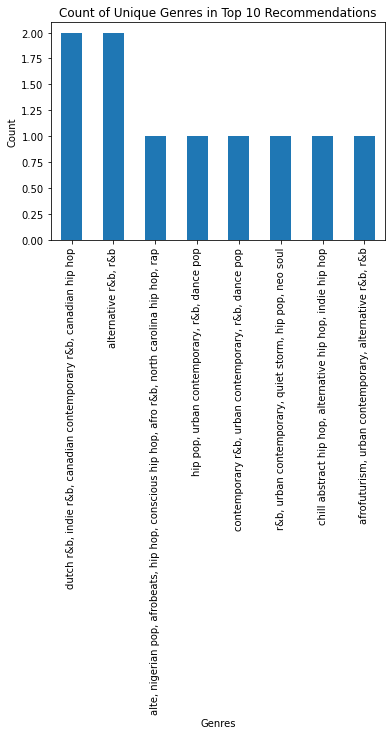

In [29]:
top_recommendations = top_recommendations.head(10)
top_recommendations['tokenized_genres'] = top_recommendations['track_genres'].apply(lambda x: x.split(', ')) # Code adapted from: https://git.arts.ac.uk/lmccallum/nlp-22-23/blob/main/NLP%20Week%202.1-Text%20as%20Numbers-class.ipynb
print(top_recommendations['tokenized_genres'])
top_genres = top_recommendations['track_genres'].tolist() # function to split data frame column of list into multiple suggested from https://stackoverflow.com/questions/35491274/split-a-pandas-column-of-lists-into-multiple-columns

# Count the number of unique genres
unique_genres_count = len(set(top_genres)) # code adapted from https://codingnomads.com/blog/data-analysis-example-analyzing-movie-ratings-with-python. I needed to 
print(f"Number of unique genres in the first 10 recommendations: {unique_genres_count}")

# Plot the count of unique genres
# Plotting code adapted from ; https://git.arts.ac.uk/lmccallum/STEM-4-Creatives-23-24/blob/main/STEM_Week_3.ipynb
genre_counts = pd.Series(top_genres).value_counts()
genre_counts.plot(kind='bar', rot=90)
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Count of Unique Genres in Top 10 Recommendations')
plt.tight_layout()
plt.show()

In [32]:
# Tokenizing the genre column for a better representation of genre ratio recommended by user popularity for the song 'Waiting For You'
all_genres = [genre for sublist in top_recommendations['tokenized_genres'] for genre in sublist]

# Calculate the number of unique genres
unique_genres_count = len(set(all_genres))

# Print the number of unique genres
print(f"Number of unique genres in the recommendations: {unique_genres_count}")


Number of unique genres in the recommendations: 24


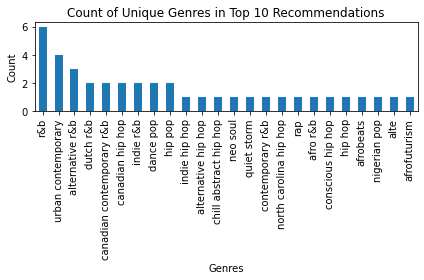

In [33]:
# Plot the above
# Count the frequency each unique genre
genre_counts = pd.Series([genre for sublist in top_recommendations['tokenized_genres'] for genre in sublist]).value_counts() # Code adapted from https://stackoverflow.com/questions/65324814/how-could-i-count-all-the-genres-in-my-dataframe and debugged with GPT.

# Plot the count of unique genres
import matplotlib.pyplot as plt

genre_counts.plot(kind='bar', rot=90)
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Count of Unique Genres in Top 10 Recommendations')
plt.tight_layout()
plt.show()

### User Profiling 
- How could my listening history have impacted the songs recommended by Spotify under the 'Waiting For you' radio?
- Comparing my top 50 tracks audio values with that of the audio values within my recommended radio for 'Waiting For You'

In [64]:
# code adapted from https://github.com/spotify/web-api-examples/blob/master/get_user_profile/src/script.ts, https://developer.spotify.com/documentation/web-api/howtos/web-app-profile and debugged using GPT.
# The following code creates a data sheet of my own personal listening activity and has already been run to create 'user_data.csv'.The credentials have been removed for privacy.
# I also incorporated the audio feature code from above to be able to compare my top 50 track's audio values to the waiting for you radio for insights.
# Does not require re-running

from spotipy.oauth2 import SpotifyOAuth

SPOTIFY_CLIENT_ID = 'x'
SPOTIFY_CLIENT_SECRET = 'y'

# Define the scope for the necessary permissions
scope = 'user-read-private user-read-email user-library-read playlist-read-private user-top-read'

# Set up authentication
sp_oauth = SpotifyOAuth(client_id='x', 
                        client_secret='y', 
                        redirect_uri='https://blank.page', 
                        scope=scope)

def get_user_data():
    # Retrieve the access token
    token_info = sp_oauth.get_cached_token()

    if not token_info:
        import webbrowser
        webbrowser.open(sp_oauth.get_authorize_url())
        response = input('Enter the URL you were redirected to: ')
        code = sp_oauth.parse_response_code(response)
        token_info = sp_oauth.get_access_token(code)

    sp = spotipy.Spotify(auth=token_info['access_token'])

    # Fetch user data
    user_profile = sp.current_user()
    playlists = sp.current_user_playlists()

    # Check if 'top_artists' key is present in the response
    if 'items' in sp.current_user_top_artists(limit=50):
        top_artists = sp.current_user_top_artists(limit=50)['items']
    else:
        top_artists = []  # Set top_artists to an empty list if key is not present
    
    # Check if 'top_tracks' key is present in the response
    if 'items' in sp.current_user_top_tracks(limit=50):
        top_tracks = sp.current_user_top_tracks(limit=50)['items']
    else:
        top_tracks = []  # Set top_tracks to an empty list if key is not present

    #top_tracks_response = sp.current_user_top_tracks(limit=50)

    # Extract track names from the top tracks response
    #top_tracks = [{'id': track['id'], 'name': track['name']} for track in top_tracks_response['items']]

    user_data = {
        'profile': user_profile,
        'playlists': playlists['items'],
        'top_artists': top_artists,
        'top_tracks': top_tracks}
    
    return user_data

def main():
    print("Starting user data retrieval...") 
    user_data = get_user_data()
    print("User data retrieved successfully.")

    # Create DataFrames for each data type
    profile_df = pd.DataFrame([user_data['profile']])
    top_artists_df = pd.DataFrame(user_data['top_artists'])
    top_tracks_df = pd.DataFrame(user_data['top_tracks'])

    # Add 'type' column to distinguish DataFrames
    profile_df['type'] = 'profile'
    top_artists_df['type'] = 'top_artist'
    top_tracks_df['type'] = 'top_track'

    # Concatenate the DataFrames into a single DataFrame
    combined_df = pd.concat([profile_df, top_artists_df, top_tracks_df], ignore_index=True)

    # Save the combined DataFrame as a single file
    combined_df.to_csv('user_data.csv', index=False)

    # Print or analyze the DataFrames
    print('\nTop Artists:')
    print(top_artists_df.head())
    print('\nTop Tracks:')
    print(top_tracks_df.head())

    # Print or analyze the combined DataFrame
    print('\nCombined User Data:')
    print(combined_df.head())

if __name__ == '__main__':
    main()

Starting user data retrieval...
User data retrieved successfully.

Top Artists:
                                       external_urls  \
0  {'spotify': 'https://open.spotify.com/artist/2...   
1  {'spotify': 'https://open.spotify.com/artist/2...   
2  {'spotify': 'https://open.spotify.com/artist/0...   
3  {'spotify': 'https://open.spotify.com/artist/3...   
4  {'spotify': 'https://open.spotify.com/artist/6...   

                          followers                            genres  \
0    {'href': None, 'total': 76641}  [afrobeats, uk contemporary r&b]   
1   {'href': None, 'total': 125377}                                []   
2   {'href': None, 'total': 386835}                        [pop soul]   
3  {'href': None, 'total': 3389099}   [ccm, christian music, worship]   
4   {'href': None, 'total': 222158}                        [pop soul]   

                                                href                      id  \
0  https://api.spotify.com/v1/artists/2BPwxhCvvcb...  2BPwxhCvvc

### Data Cleaning 

In [78]:
# Coding principals adapted from: https://git.arts.ac.uk/lmccallum/Intro-to-ds-23-24/blob/master/intro-to-ds-week-2-cleaning-data.ipynb and https://git.arts.ac.uk/lmccallum/Intro-to-ds-23-24/blob/master/intro-to-ds-week-2-cleaning-data-task-solutions.ipynb. 
# Read the first 50 data points in my 'user_data.csv' file
df = pd.read_csv('user_data.csv')

# Remove unwanted columns and choosing the last 50 data points as they have all available data points compared to the first 50 in the .csv file.
df = df[['id', 'genres', 'name', 'popularity', 'external_urls.spotify']]

df = df.dropna()

# Get the top 50 rows
top_50_tracks = df.head(30)

# Display the top 50 rows
top_50_tracks

KeyError: "['external_urls.spotify'] not in index"

In [70]:
# Add missing audio features for comparative analysis
# This code does not need to be run, instead the relevant csv file can be found as 'updated_track_data.csv'

def get_audio_features(sp, track_id):
    # Retrieve audio features for a specific track using its track ID
    audio_features = sp.audio_features(track_id)[0]
    return audio_features

def main():
    # Define the scope for the necessary permissions
    scope = 'user-read-private user-read-email user-library-read playlist-read-private user-top-read'

    # Set up authentication
    sp_oauth = SpotifyOAuth(client_id='x', 
                            client_secret='y', 
                            redirect_uri='http://localhost:8888/callback', 
                            scope=scope)

    # Retrieve the access token
    token_info = sp_oauth.get_cached_token()

    if not token_info:
        import webbrowser
        webbrowser.open(sp_oauth.get_authorize_url())
        response = input('Enter the URL you were redirected to: ')
        code = sp_oauth.parse_response_code(response)
        token_info = sp_oauth.get_access_token(code)

    sp = spotipy.Spotify(auth=token_info['access_token'])  # Define the Spotify object 'sp'

    # Read the CSV file containing track information
    track_data = pd.read_csv('user_data.csv')

    # Create a list to store audio features for each track
    audio_features_list = []

    # Retrieve audio features for each track in the CSV data
    for index, track_row in track_data.iterrows():
        track_id = track_row['id']
        audio_features = get_audio_features(sp, track_id)
        audio_features_list.append(audio_features)

    # Add the audio features to the DataFrame
    track_data['audio_features'] = audio_features_list

    # Save the updated DataFrame with audio features to a new CSV file
    track_data.to_csv('updated_track_data.csv', index=False)

if __name__ == '__main__':
    main()

In [161]:
# View audio features
df = pd.read_csv('updated_track_data.csv')

# Access and view the 'audio_features' column
audio_features = df['audio_features']

audio_features # tokenize and seperatew the features from a sttring to an object 

0                                                   NaN
1                                                   NaN
2                                                   NaN
3                                                   NaN
4                                                   NaN
                            ...                        
95    {'danceability': 0.589, 'energy': 0.418, 'key'...
96    {'danceability': 0.207, 'energy': 0.562, 'key'...
97    {'danceability': 0.634, 'energy': 0.593, 'key'...
98    {'danceability': 0.79, 'energy': 0.762, 'key':...
99    {'danceability': 0.324, 'energy': 0.181, 'key'...
Name: audio_features, Length: 100, dtype: object

In [162]:
import ast
# GPT used here to convert the string representation of the dictionary in the 'audio_features' column into an actual dictionary, normalize it into separate columns, and concatenate the normalized audio features DataFrame with the original DataFrame.
# This was done so that i can call the audio feature data points for analysis.

df = df.dropna(subset=['audio_features'])

# Convert string representation of dictionary to actual dictionary using eval()
df['audio_features'] = df['audio_features'].apply(ast.literal_eval)

# Normalize the dictionary into separate columns using pd.json_normalize()
audio_features_df = pd.json_normalize(df['audio_features'])

# Concatenate the normalized audio features DataFrame with the original DataFrame
df = pd.concat([df, audio_features_df], axis=1)

# Drop the original 'audio_features' column
df = df.drop('audio_features', axis=1)

# Clean the data by removing unwanted characters and spaces
df = df.applymap(lambda x: x.strip().replace('[', '').replace(']', '').replace(';', '').replace('/', '') if isinstance(x, str) else x)

# Print the DataFrame with each audio feature in its own column
print(df)

    display_name                                      external_urls  \
50           NaN  {'spotify': 'https:open.spotify.comtrack1whAXV...   
51           NaN  {'spotify': 'https:open.spotify.comtrack0nBSRI...   
52           NaN  {'spotify': 'https:open.spotify.comtrack6TQtwV...   
53           NaN  {'spotify': 'https:open.spotify.comtrack5jIPK0...   
54           NaN  {'spotify': 'https:open.spotify.comtrack5Ztqkk...   
..           ...                                                ...   
45           NaN                                                NaN   
46           NaN                                                NaN   
47           NaN                                                NaN   
48           NaN                                                NaN   
49           NaN                                                NaN   

                                                 href                      id  \
50  https:api.spotify.comv1tracks1whAXVGN8AdfrnoXN...  1whAXVGN8Ad

### Drawing insights and data visualization

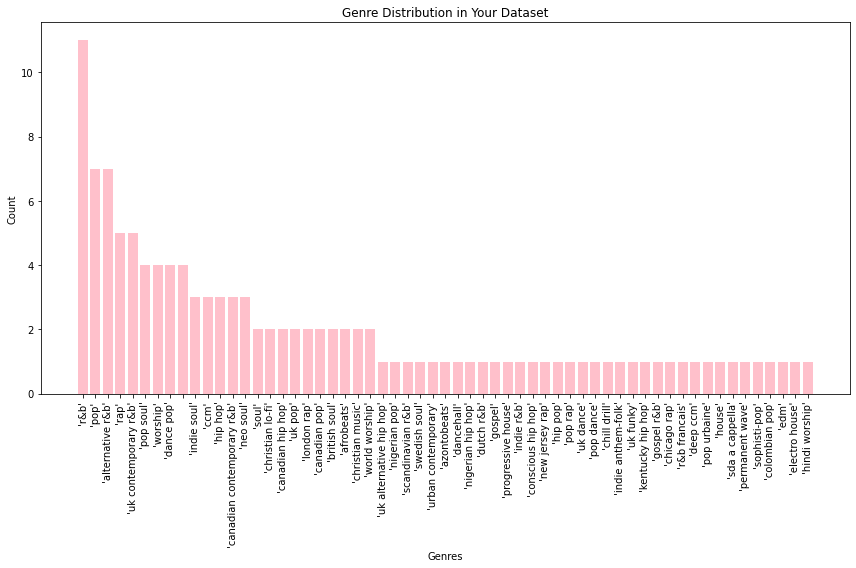

In [163]:
# Personal genre distribution with 100 samples
# Code adapted from https://git.arts.ac.uk/lmccallum/Intro-to-ds-23-24/blob/master/intro_to_ds_week_4-Continuous-Probabilities.ipynb and debugged using GPT.
import scipy.stats as st

df = pd.read_csv('updated_track_data.csv')

# Drop rows with NaN values in the 'genres' column
df = df.dropna(subset=['genres'])

# Convert string representation of dictionary to actual dictionary using eval()
df['audio_features'] = df['audio_features'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Normalize the dictionary into separate columns using pd.json_normalize()
audio_features_df = pd.json_normalize(df['audio_features'])

# Concatenate the normalized audio features DataFrame with the original DataFrame
df = pd.concat([df, audio_features_df], axis=1)

# Removing unwanted characters and spaces
df = df.applymap(lambda x: x.strip().replace('[', '').replace(']', '').replace(';', '').replace('/', '') if isinstance(x, str) else x)

# Process the data for genre distribution
genre_series = df['genres'].str.split(', ', expand=True).stack()
genre_counts = genre_series.value_counts()

# Drop NaN values in genre_counts if present
genre_counts = genre_counts.dropna()

if genre_counts.empty:
    print("No genre data to plot.")
else:
    
    # Plot 
    plt.figure(figsize=(12, 8))
    plt.bar(range(len(genre_counts)), genre_counts, color='pink')
    plt.xticks(range(len(genre_counts)), genre_counts.index, rotation=90)
    plt.xlabel('Genres')
    plt.ylabel('Count')
    plt.title('Genre Distribution in Your Dataset')
    plt.tight_layout()
    plt.show()

In [164]:
# Load your data into a DataFrame
df = pd.read_csv('updated_track_data.csv')
df

,display_name,external_urls,href,id,images,type,uri,followers,country,product,...,artists,available_markets,disc_number,duration_ms,explicit,external_ids,is_local,preview_url,track_number,audio_features
0,NaN,{'spotify': 'https://open.spotify.com/artist/2...,https://api.spotify.com/v1/artists/2BPwxhCvvcb...,2BPwxhCvvcb8xDl8GWIjbh,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",top_artist,spotify:artist:2BPwxhCvvcb8xDl8GWIjbh,"{'href': None, 'total': 76641}",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,{'spotify': 'https://open.spotify.com/artist/2...,https://api.spotify.com/v1/artists/2PCl4hx9Qds...,2PCl4hx9Qds8sjcnoWUdqp,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",top_artist,spotify:artist:2PCl4hx9Qds8sjcnoWUdqp,"{'href': None, 'total': 125377}",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,{'spotify': 'https://open.spotify.com/artist/0...,https://api.spotify.com/v1/artists/00x1fYSGhdq...,00x1fYSGhdqScXBRpSj3DW,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",top_artist,spotify:artist:00x1fYSGhdqScXBRpSj3DW,"{'href': None, 'total': 386835}",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,{'spotify': 'https://open.spotify.com/artist/3...,https://api.spotify.com/v1/artists/3YCKuqpv9nC...,3YCKuqpv9nCsIhJ2v8SMix,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",top_artist,spotify:artist:3YCKuqpv9nCsIhJ2v8SMix,"{'href': None, 'total': 3389099}",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,{'spotify': 'https://open.spotify.com/artist/6...,https://api.spotify.com/v1/artists/6eAUAR4N9NO...,6eAUAR4N9NOpirukqdIzVI,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",top_artist,spotify:artist:6eAUAR4N9NOpirukqdIzVI,"{'href': None, 'total': 222158}",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,{'spotify': 'https://open.spotify.com/track/4u...,https://api.spotify.com/v1/tracks/4uawMXx8VZ7W...,4uawMXx8VZ7WMrjAVOaCMe,NaN,top_track,spotify:track:4uawMXx8VZ7WMrjAVOaCMe,NaN,NaN,NaN,...,[{'external_urls': {'spotify': 'https://open.s...,"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1.0,292506.0,False,{'isrc': 'GBAHT2000172'},False,https://p.scdn.co/mp3-preview/f3fb6a03bf70b6c2...,1.0,"{'danceability': 0.589, 'energy': 0.418, 'key'..."
96,NaN,{'spotify': 'https://open.spotify.com/track/1g...,https://api.spotify.com/v1/tracks/1gyEX2oRrnaV...,1gyEX2oRrnaVX0RrOFc0ys,NaN,top_track,spotify:track:1gyEX2oRrnaVX0RrOFc0ys,NaN,NaN,NaN,...,[{'external_urls': {'spotify': 'https://open.s...,"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1.0,377376.0,False,{'isrc': 'TCADF1772445'},False,https://p.scdn.co/mp3-preview/cfdfc1f7c36b01c4...,1.0,"{'danceability': 0.207, 'energy': 0.562, 'key'..."
97,NaN,{'spotify': 'https://open.spotify.com/track/5v...,https://api.spotify.com/v1/tracks/5vqjvuNViINn...,5vqjvuNViINnypB6MqDSMB,NaN,top_track,spotify:track:5vqjvuNViINnypB6MqDSMB,NaN,NaN,NaN,...,[{'external_urls': {'spotify': 'https://open.s...,"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1.0,235568.0,False,{'isrc': 'GBKPL1824207'},False,NaN,3.0,"{'danceability': 0.634, 'energy': 0.593, 'key'..."
98,NaN,{'spotify': 'https://open.spotify.com/track/5Q...,https://api.spotify.com/v1/tracks/5Q4JduIFVtir...,5Q4JduIFVtirezPnU9RggG,NaN,top_track,spotify:track:5Q4JduIFVtirezPnU9RggG,NaN,NaN,NaN,...,[{'external_urls': {'spotify': 'https://open.s...,"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1.0,170322.0,False,{'isrc': 'QM6P42325564'},False,https://p.scdn.co/mp3-preview/da98f4462c5ff4bc...,4.0,"{'danceability': 0.79, 'energy': 0.762, 'key':..."


### Statistical Analysis
- Is there any statistical differences in the audio features between the 'ghost' and personal account?

In [204]:
from scipy.stats import ttest_1samp
# Debugged with GPT 

# Load ypeersonal data
df = pd.read_csv('updated_track_data.csv')

# Drop rows with NaN values in the audio features
df = df.dropna(subset=['audio_features'])

# Convert the 'audio_features' column to separate columns
df['audio_features'] = df['audio_features'].apply(eval)  # Convert string to dictionary
audio_features_df = df['audio_features'].apply(pd.Series)
df = pd.concat([df, audio_features_df], axis=1).drop('audio_features', axis=1)


# Convert the 'audio_features' column to separate columns
#audio_features_df = df['audio_features'].apply(eval).apply(pd.Series)
#df = pd.concat([df, audio_features_df], axis=1).drop('audio_features', axis=1)

df

,display_name,external_urls,href,id,images,type,uri,followers,country,product,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
50,NaN,{'spotify': 'https://open.spotify.com/track/1w...,https://api.spotify.com/v1/tracks/1whAXVGN8Adf...,1whAXVGN8AdfrnoXNIXfJf,NaN,top_track,spotify:track:1whAXVGN8AdfrnoXNIXfJf,NaN,NaN,NaN,...,0.0854,0.8050,154.255,audio_features,1whAXVGN8AdfrnoXNIXfJf,spotify:track:1whAXVGN8AdfrnoXNIXfJf,https://api.spotify.com/v1/tracks/1whAXVGN8Adf...,https://api.spotify.com/v1/audio-analysis/1whA...,190393,5
51,NaN,{'spotify': 'https://open.spotify.com/track/0n...,https://api.spotify.com/v1/tracks/0nBSRIzgxIb0...,0nBSRIzgxIb08xXgiEBZWi,NaN,top_track,spotify:track:0nBSRIzgxIb08xXgiEBZWi,NaN,NaN,NaN,...,0.0935,0.3660,109.018,audio_features,0nBSRIzgxIb08xXgiEBZWi,spotify:track:0nBSRIzgxIb08xXgiEBZWi,https://api.spotify.com/v1/tracks/0nBSRIzgxIb0...,https://api.spotify.com/v1/audio-analysis/0nBS...,203670,4
52,NaN,{'spotify': 'https://open.spotify.com/track/6T...,https://api.spotify.com/v1/tracks/6TQtwV4QG19S...,6TQtwV4QG19SzCVG5F2RkC,NaN,top_track,spotify:track:6TQtwV4QG19SzCVG5F2RkC,NaN,NaN,NaN,...,0.0972,0.5930,95.367,audio_features,6TQtwV4QG19SzCVG5F2RkC,spotify:track:6TQtwV4QG19SzCVG5F2RkC,https://api.spotify.com/v1/tracks/6TQtwV4QG19S...,https://api.spotify.com/v1/audio-analysis/6TQt...,153648,4
53,NaN,{'spotify': 'https://open.spotify.com/track/5j...,https://api.spotify.com/v1/tracks/5jIPK0iZ3wzC...,5jIPK0iZ3wzCHWsEze021Z,NaN,top_track,spotify:track:5jIPK0iZ3wzCHWsEze021Z,NaN,NaN,NaN,...,0.0661,0.4160,87.911,audio_features,5jIPK0iZ3wzCHWsEze021Z,spotify:track:5jIPK0iZ3wzCHWsEze021Z,https://api.spotify.com/v1/tracks/5jIPK0iZ3wzC...,https://api.spotify.com/v1/audio-analysis/5jIP...,148750,4
54,NaN,{'spotify': 'https://open.spotify.com/track/5Z...,https://api.spotify.com/v1/tracks/5ZtqkkX8XRfg...,5ZtqkkX8XRfgmgxnxedI0C,NaN,top_track,spotify:track:5ZtqkkX8XRfgmgxnxedI0C,NaN,NaN,NaN,...,0.0799,0.5190,89.660,audio_features,5ZtqkkX8XRfgmgxnxedI0C,spotify:track:5ZtqkkX8XRfgmgxnxedI0C,https://api.spotify.com/v1/tracks/5ZtqkkX8XRfg...,https://api.spotify.com/v1/audio-analysis/5Ztq...,210100,4
55,NaN,{'spotify': 'https://open.spotify.com/track/0L...,https://api.spotify.com/v1/tracks/0LxTBLGeMgCT...,0LxTBLGeMgCTJZvcX8rI4c,NaN,top_track,spotify:track:0LxTBLGeMgCTJZvcX8rI4c,NaN,NaN,NaN,...,0.2350,0.7180,84.493,audio_features,0LxTBLGeMgCTJZvcX8rI4c,spotify:track:0LxTBLGeMgCTJZvcX8rI4c,https://api.spotify.com/v1/tracks/0LxTBLGeMgCT...,https://api.spotify.com/v1/audio-analysis/0LxT...,68174,4
56,NaN,{'spotify': 'https://open.spotify.com/track/1j...,https://api.spotify.com/v1/tracks/1jkIBUxmccro...,1jkIBUxmccrozUCPUzbZR7,NaN,top_track,spotify:track:1jkIBUxmccrozUCPUzbZR7,NaN,NaN,NaN,...,0.0869,0.4290,179.970,audio_features,1jkIBUxmccrozUCPUzbZR7,spotify:track:1jkIBUxmccrozUCPUzbZR7,https://api.spotify.com/v1/tracks/1jkIBUxmccro...,https://api.spotify.com/v1/audio-analysis/1jkI...,142520,4
57,NaN,{'spotify': 'https://open.spotify.com/track/6D...,https://api.spotify.com/v1/tracks/6Dae6DNW72nL...,6Dae6DNW72nLZ6KGyE7aeH,NaN,top_track,spotify:track:6Dae6DNW72nLZ6KGyE7aeH,NaN,NaN,NaN,...,0.1050,0.5810,81.976,audio_features,6Dae6DNW72nLZ6KGyE7aeH,spotify:track:6Dae6DNW72nLZ6KGyE7aeH,https://api.spotify.com/v1/tracks/6Dae6DNW72nL...,https://api.spotify.com/v1/audio-analysis/6Dae...,219999,4
58,NaN,{'spotify': 'https://open.spotify.com/track/4t...,https://api.spotify.com/v1/tracks/4tPtlrjm8RxU...,4tPtlrjm8RxUjym8UaH2Ap,NaN,top_track,spotify:track:4tPtlrjm8RxUjym8UaH2Ap,NaN,NaN,NaN,...,0.1090,0.1590,116.031,audio_features,4tPtlrjm8RxUjym8UaH2Ap,spotify:track:4tPtlrjm8RxUjym8UaH2Ap,https://api.spotify.com/v1/tracks/4tPtlrjm8RxU...,https://api.spotify.com/v1/audio-analysis/4tPt...,206995,4
59,NaN,{'spotify': 'https://open.spotify.com/track/1r...,https://api.spotify.com/v1/tracks/1r16zpUZ2nH4...,1r16zpUZ2nH44uOXlBGrbm,NaN,top_track,spotify:track:1r16zpUZ2nH44uOXlBGrbm,NaN,NaN,NaN,...,0.0875,0.7590,

In [205]:
# Update csv file with audio features
df = pd.read_csv('updated_track_data.csv')

# Drop rows with NaN values in the audio features
# Debugged with GPT
df = df.dropna(subset=['audio_features'])

# Convert the 'audio_features' column to separate columns
df['audio_features'] = df['audio_features'].apply(eval)  # Convert string to dictionary
audio_features_df = df['audio_features'].apply(pd.Series)
df = pd.concat([df, audio_features_df], axis=1).drop('audio_features', axis=1)

# Save the updated DataFrame back to 'updated_track_data.csv'
df.to_csv('updated_track_data.csv', index=False)

df

,display_name,external_urls,href,id,images,type,uri,followers,country,product,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
50,NaN,{'spotify': 'https://open.spotify.com/track/1w...,https://api.spotify.com/v1/tracks/1whAXVGN8Adf...,1whAXVGN8AdfrnoXNIXfJf,NaN,top_track,spotify:track:1whAXVGN8AdfrnoXNIXfJf,NaN,NaN,NaN,...,0.0854,0.8050,154.255,audio_features,1whAXVGN8AdfrnoXNIXfJf,spotify:track:1whAXVGN8AdfrnoXNIXfJf,https://api.spotify.com/v1/tracks/1whAXVGN8Adf...,https://api.spotify.com/v1/audio-analysis/1whA...,190393,5
51,NaN,{'spotify': 'https://open.spotify.com/track/0n...,https://api.spotify.com/v1/tracks/0nBSRIzgxIb0...,0nBSRIzgxIb08xXgiEBZWi,NaN,top_track,spotify:track:0nBSRIzgxIb08xXgiEBZWi,NaN,NaN,NaN,...,0.0935,0.3660,109.018,audio_features,0nBSRIzgxIb08xXgiEBZWi,spotify:track:0nBSRIzgxIb08xXgiEBZWi,https://api.spotify.com/v1/tracks/0nBSRIzgxIb0...,https://api.spotify.com/v1/audio-analysis/0nBS...,203670,4
52,NaN,{'spotify': 'https://open.spotify.com/track/6T...,https://api.spotify.com/v1/tracks/6TQtwV4QG19S...,6TQtwV4QG19SzCVG5F2RkC,NaN,top_track,spotify:track:6TQtwV4QG19SzCVG5F2RkC,NaN,NaN,NaN,...,0.0972,0.5930,95.367,audio_features,6TQtwV4QG19SzCVG5F2RkC,spotify:track:6TQtwV4QG19SzCVG5F2RkC,https://api.spotify.com/v1/tracks/6TQtwV4QG19S...,https://api.spotify.com/v1/audio-analysis/6TQt...,153648,4
53,NaN,{'spotify': 'https://open.spotify.com/track/5j...,https://api.spotify.com/v1/tracks/5jIPK0iZ3wzC...,5jIPK0iZ3wzCHWsEze021Z,NaN,top_track,spotify:track:5jIPK0iZ3wzCHWsEze021Z,NaN,NaN,NaN,...,0.0661,0.4160,87.911,audio_features,5jIPK0iZ3wzCHWsEze021Z,spotify:track:5jIPK0iZ3wzCHWsEze021Z,https://api.spotify.com/v1/tracks/5jIPK0iZ3wzC...,https://api.spotify.com/v1/audio-analysis/5jIP...,148750,4
54,NaN,{'spotify': 'https://open.spotify.com/track/5Z...,https://api.spotify.com/v1/tracks/5ZtqkkX8XRfg...,5ZtqkkX8XRfgmgxnxedI0C,NaN,top_track,spotify:track:5ZtqkkX8XRfgmgxnxedI0C,NaN,NaN,NaN,...,0.0799,0.5190,89.660,audio_features,5ZtqkkX8XRfgmgxnxedI0C,spotify:track:5ZtqkkX8XRfgmgxnxedI0C,https://api.spotify.com/v1/tracks/5ZtqkkX8XRfg...,https://api.spotify.com/v1/audio-analysis/5Ztq...,210100,4
55,NaN,{'spotify': 'https://open.spotify.com/track/0L...,https://api.spotify.com/v1/tracks/0LxTBLGeMgCT...,0LxTBLGeMgCTJZvcX8rI4c,NaN,top_track,spotify:track:0LxTBLGeMgCTJZvcX8rI4c,NaN,NaN,NaN,...,0.2350,0.7180,84.493,audio_features,0LxTBLGeMgCTJZvcX8rI4c,spotify:track:0LxTBLGeMgCTJZvcX8rI4c,https://api.spotify.com/v1/tracks/0LxTBLGeMgCT...,https://api.spotify.com/v1/audio-analysis/0LxT...,68174,4
56,NaN,{'spotify': 'https://open.spotify.com/track/1j...,https://api.spotify.com/v1/tracks/1jkIBUxmccro...,1jkIBUxmccrozUCPUzbZR7,NaN,top_track,spotify:track:1jkIBUxmccrozUCPUzbZR7,NaN,NaN,NaN,...,0.0869,0.4290,179.970,audio_features,1jkIBUxmccrozUCPUzbZR7,spotify:track:1jkIBUxmccrozUCPUzbZR7,https://api.spotify.com/v1/tracks/1jkIBUxmccro...,https://api.spotify.com/v1/audio-analysis/1jkI...,142520,4
57,NaN,{'spotify': 'https://open.spotify.com/track/6D...,https://api.spotify.com/v1/tracks/6Dae6DNW72nL...,6Dae6DNW72nLZ6KGyE7aeH,NaN,top_track,spotify:track:6Dae6DNW72nLZ6KGyE7aeH,NaN,NaN,NaN,...,0.1050,0.5810,81.976,audio_features,6Dae6DNW72nLZ6KGyE7aeH,spotify:track:6Dae6DNW72nLZ6KGyE7aeH,https://api.spotify.com/v1/tracks/6Dae6DNW72nL...,https://api.spotify.com/v1/audio-analysis/6Dae...,219999,4
58,NaN,{'spotify': 'https://open.spotify.com/track/4t...,https://api.spotify.com/v1/tracks/4tPtlrjm8RxU...,4tPtlrjm8RxUjym8UaH2Ap,NaN,top_track,spotify:track:4tPtlrjm8RxUjym8UaH2Ap,NaN,NaN,NaN,...,0.1090,0.1590,116.031,audio_features,4tPtlrjm8RxUjym8UaH2Ap,spotify:track:4tPtlrjm8RxUjym8UaH2Ap,https://api.spotify.com/v1/tracks/4tPtlrjm8RxU...,https://api.spotify.com/v1/audio-analysis/4tPt...,206995,4
59,NaN,{'spotify': 'https://open.spotify.com/track/1r...,https://api.spotify.com/v1/tracks/1r16zpUZ2nH4...,1r16zpUZ2nH44uOXlBGrbm,NaN,top_track,spotify:track:1r16zpUZ2nH44uOXlBGrbm,NaN,NaN,NaN,...,0.0875,0.7590,

In [206]:
audio_features_list = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Match column numbers and names for the specified audio features
column_mapping = {col: df.columns.get_loc(col) for col in audio_features_list}

# Print the column numbers and names for the specified audio features
for feature, column_number in column_mapping.items():
    print(f"Column Number for {feature}: {column_number}, Column Name: {df.columns[column_number]}")

Column Number for danceability: 25, Column Name: danceability
Column Number for energy: 26, Column Name: energy
Column Number for key: 27, Column Name: key
Column Number for loudness: 28, Column Name: loudness
Column Number for mode: 29, Column Name: mode
Column Number for speechiness: 30, Column Name: speechiness
Column Number for acousticness: 31, Column Name: acousticness
Column Number for instrumentalness: 32, Column Name: instrumentalness
Column Number for liveness: 33, Column Name: liveness
Column Number for valence: 34, Column Name: valence
Column Number for tempo: 35, Column Name: tempo


###  'Ghost' account 
- Code adapted from : https://git.arts.ac.uk/lmccallum/personalisation-23-24/blob/main/week-3-spotify-playlists.ipynb


In [ ]:
scope = 'playlist-read-private'
SPOTIFY_CLIENT_ID = '3e62f28b71214ae59c2cefd5deaa25ef'
SPOTIFY_CLIENT_SECRET = 'cc4de7d9489540b99368b7d2b4d5f7e4'
PLAYLIST_ID = '37i9dQZF1E8MiB8GbChyWl'

# Set up authentication with Client Credentials Flow
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Get the playlist tracks
playlist_tracks = sp.playlist_tracks(PLAYLIST_ID)

# Extract track IDs
track_ids = [track['track']['id'] for track in playlist_tracks['items']]

# Get audio features for tracks
audio_features = pd.DataFrame(sp.audio_features(track_ids))

# Save the audio features to a CSV file
audio_features.to_csv('ghost_playlist_audio_features.csv', index=False)
audio_features

In [200]:
# Need to target the correct columns for my audio features, print
audio_features = pd.read_csv('ghost_playlist_audio_features.csv')


for idx, column_name in enumerate(audio_features.columns): # needed to enumerate for specific items in my column list. Code adapted from: https://stackoverflow.com/questions/724856/picking-out-items-from-a-python-list-which-have-specific-indexes.
    print(f"Column Number: {idx}, Column Name: {column_name}")

Column Number: 0, Column Name: danceability
Column Number: 1, Column Name: energy
Column Number: 2, Column Name: key
Column Number: 3, Column Name: loudness
Column Number: 4, Column Name: mode
Column Number: 5, Column Name: speechiness
Column Number: 6, Column Name: acousticness
Column Number: 7, Column Name: instrumentalness
Column Number: 8, Column Name: liveness
Column Number: 9, Column Name: valence
Column Number: 10, Column Name: tempo
Column Number: 11, Column Name: type
Column Number: 12, Column Name: id
Column Number: 13, Column Name: uri
Column Number: 14, Column Name: track_href
Column Number: 15, Column Name: analysis_url
Column Number: 16, Column Name: duration_ms
Column Number: 17, Column Name: time_signature


### T-Test for statistical comparison
-  Each dataset has its own set of column numbers where the audio features are located thus I would need to consider the column mappings for both datasets.

In [207]:
from scipy.stats import ttest_ind

# Load the data from 'ghost_playlist_audio_features.csv' and 'updated_track_data.csv'
ghost_df = pd.read_csv('ghost_playlist_audio_features.csv')
updated_df = pd.read_csv('updated_track_data.csv')

# Map column names to column numbers for selected audio features in your ghost data
ghost_audio_features_mapping = {
    'danceability': 0,
    'energy': 1,
    'key': 2,
    'loudness': 3,
    'mode': 4,
    'speechiness': 5,
    'acousticness': 6
}

# Map column names to column numbers for selected audio features in your personal data
personal_audio_features_mapping = {
    'danceability': 25,
    'energy': 26,
    'key': 27,
    'loudness': 28,
    'mode': 29,
    'speechiness': 30,
    'acousticness': 31,
    'instrumentalness': 32,
    'liveness': 33,
    'valence': 34,
    'tempo': 35
}

# Manually select columns by index positions for comparison
selected_features_ghost = [ghost_audio_features_mapping[feature] for feature in ghost_audio_features_mapping]
selected_features_personal = [personal_audio_features_mapping[feature] for feature in personal_audio_features_mapping]

# Drop rows with NaN values in the selected audio features
ghost_df = ghost_df.dropna(subset=ghost_df.columns[selected_features_ghost])
updated_df = updated_df.dropna(subset=updated_df.columns[selected_features_personal])

# Perform t-test for the selected audio features
for feature_idx_ghost, feature_idx_personal in zip(selected_features_ghost, selected_features_personal):
    t_stat, p_value = ttest_ind(ghost_df.iloc[:, feature_idx_ghost], updated_df.iloc[:, feature_idx_personal], equal_var=False)
    print(f"Audio Feature Index - Ghost: {feature_idx_ghost}, Personal: {feature_idx_personal}")
    print(f"T-Statistic: {t_stat}")
    print(f"P-Value: {p_value}")

    # Interpret the results based on the p-value
    if p_value < 0.05:
        print("There is a statistically significant difference in the means of the selected audio feature.")
    else:
        print("There is no statistically significant difference in the means of the selected audio feature.")
    print()

Audio Feature Index - Ghost: 0, Personal: 25
T-Statistic: 0.9582254233130664
P-Value: 0.34053460849309514
There is no statistically significant difference in the means of the selected audio feature.

Audio Feature Index - Ghost: 1, Personal: 26
T-Statistic: -4.880138067250321
P-Value: 4.2124970166153365e-06
There is a statistically significant difference in the means of the selected audio feature.

Audio Feature Index - Ghost: 2, Personal: 27
T-Statistic: -1.0978026171527107
P-Value: 0.2749941138129153
There is no statistically significant difference in the means of the selected audio feature.

Audio Feature Index - Ghost: 3, Personal: 28
T-Statistic: -3.505675297919728
P-Value: 0.000688905818359639
There is a statistically significant difference in the means of the selected audio feature.

Audio Feature Index - Ghost: 4, Personal: 29
T-Statistic: -0.6100425384628332
P-Value: 0.5432467234371245
There is no statistically significant difference in the means of the selected audio feature.